In [2]:
# Initial Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

### 1. Load and Prepare Data

In [3]:
# Mount Google Drive with data
from google.colab import drive
drive.mount('/content/drive')
clear_output

Mounted at /content/drive


<function IPython.core.display.clear_output(wait=False)>

In [4]:
def calculate_new_values(row):
    row['LF'] = (row['LF'] * row['Raw_Sum']) / 100
    row['LH'] = (row['LH'] * row['Raw_Sum']) / 100
    row['RF'] = (row['RF'] * row['Raw_Sum']) / 100
    row['RH'] = (row['RH'] * row['Raw_Sum']) / 100
    return row

In [5]:
# Load Excel sheet with  data of Young Dogs
dogs = pd.read_excel("/content/drive/Shareddrives/NNDL_Project/Young dog OA grouping.xlsx")

# Define the main directory path
main_directory = "/content/drive/Shareddrives/NNDL_Project"

# Initialize an empty dictionary to store DataFrames
dataframes = {}
columns = ['Frame', 'Time', 'Absolute_Time', 'Raw_Sum', 'LF', 'LH','RF', 'RH']
# Iterate over directories in the main directory
for root, dirs, files in os.walk(main_directory):
    for dir_name in dirs:
        if dir_name in ['Finn Cray']:
              continue
        dir_path = os.path.join(root, dir_name)
        # Iterate over files in the current directory
        for filename in os.listdir(dir_path):

            if filename.endswith("_G.csv"):  # Check if the file name ends with "_G.csv"
                file_path = os.path.join(dir_path, filename)  # Get the full file path
                # Read the CSV file into a DataFrame and store it in the dictionary
                df = pd.read_csv(file_path,skiprows=41,names=columns,skipfooter=1)
                if len(df) != 0:
                  if dir_name not in dataframes.keys():
                    dataframes[dir_name] = {}
                  df = df.drop(columns=['Frame', 'Time', 'Absolute_Time'])
                  df = df[df['Raw_Sum'] != 0]
                  df = df.apply(calculate_new_values, axis=1)
                  df = df.drop(columns=['Raw_Sum'])
                  # for column in df.columns:
                  #   df[column] = df[column]  / df[column].abs().max()
                  dataframes[dir_name][filename]= df
                #Remove rows with Rawsum equal to zero
                # dataframes[dir_name][filename] = dataframes[dir_name][filename][(dataframes[dir_name][filename]['Raw_Sum'] > 0)]

# Print the keys (file names) in the dictionary
print("CSV files ending with '_G' loaded into separate DataFrames:")
print(list(dataframes.keys()))

CSV files ending with '_G' loaded into separate DataFrames:
['Mase Moore', 'Loretta Cullen', 'Tucker Baucomb', 'Turks Forester', 'Artemis McCallister', 'Bruno Mckeon', 'Danika Vargas', 'Dulla Brackett', 'Einstein Chappelle', 'Emma Rivera', 'Indy Wolfe', 'Poppy Case', 'Katie Piojda', 'Gryffin Frank', 'Teddy Krahe', 'Lexi Green', 'Abbi Dillard', 'Abigail Vargas', 'Ziva Mitchell', 'Josie Hammond', 'Finnigan Fox', 'Archie Casavant']


In [6]:
print(list(dataframes.keys()))

['Mase Moore', 'Loretta Cullen', 'Tucker Baucomb', 'Turks Forester', 'Artemis McCallister', 'Bruno Mckeon', 'Danika Vargas', 'Dulla Brackett', 'Einstein Chappelle', 'Emma Rivera', 'Indy Wolfe', 'Poppy Case', 'Katie Piojda', 'Gryffin Frank', 'Teddy Krahe', 'Lexi Green', 'Abbi Dillard', 'Abigail Vargas', 'Ziva Mitchell', 'Josie Hammond', 'Finnigan Fox', 'Archie Casavant']


In [7]:
dataframes['Mase Moore']

{'CheeM01_G.csv':         LF   LH     RF   RH
 232    0.0  0.0   37.0  0.0
 233    0.0  0.0   51.0  0.0
 234    0.0  0.0   94.0  0.0
 235    0.0  0.0  148.0  0.0
 236    0.0  0.0  172.0  0.0
 ..     ...  ...    ...  ...
 518  312.0  0.0    0.0  0.0
 519  260.0  0.0    0.0  0.0
 520  197.0  0.0    0.0  0.0
 521  109.0  0.0    0.0  0.0
 522   42.0  0.0    0.0  0.0
 
 [291 rows x 4 columns],
 'CheeM02_G.csv':       LF     LH   RF     RH
 177  0.0    0.0  0.0    0.0
 178  0.0    0.0  0.0   70.0
 179  0.0    0.0  0.0  122.0
 180  0.0    0.0  0.0  193.0
 181  0.0    0.0  0.0  241.0
 ..   ...    ...  ...    ...
 399  0.0  222.0  0.0    0.0
 400  0.0  186.0  0.0    0.0
 401  0.0  139.0  0.0    0.0
 402  0.0   82.0  0.0    0.0
 403  0.0   46.0  0.0    0.0
 
 [227 rows x 4 columns],
 'CheeM03_G.csv':         LF   LH   RF     RH
 176    0.0  0.0  0.0   49.0
 177    0.0  0.0  0.0   86.0
 178    0.0  0.0  0.0  132.0
 179    0.0  0.0  0.0  208.0
 180    0.0  0.0  0.0  246.0
 ..     ...  ...  ...    

In [8]:
def get_label(Name):
  label = dogs[dogs['Patient Name (first, last)'] == Name].Group.values[0]
  if label == 'cOA1':
    return 1
  if label == 'rOA':
    return 2
  else:
    return 0

In [9]:
min_len = 120

In [10]:
sequences =[]
labels = []
for doggy in dataframes.keys():
  for filename in dataframes[doggy]:
    strt = 0
    if len(dataframes[doggy][filename])>min_len:
      for k in range(math.ceil(len(dataframes[doggy][filename])-min_len)):
        sequence_features= dataframes[doggy][filename][strt: strt+min_len]
        label = get_label(doggy)
        strt+=1
        sequences.append(sequence_features.to_numpy())
        labels.append(label)


In [11]:
Counter(labels)

Counter({0: 10332, 1: 9939, 2: 12128})

In [12]:
num_classes = 3

# Perform one-hot encoding
one_hot_encoded = np.eye(num_classes)[labels]

In [13]:
one_hot_encoded.shape

(32399, 3)

In [14]:
labels = np.array(labels)

In [15]:
len(sequences)

32399

In [16]:
len(one_hot_encoded)

32399

In [17]:
sequences = np.array(sequences)

In [18]:
sequences.shape

(32399, 120, 4)

In [19]:
sequences[0]

array([[   0.   ,    0.   ,   37.   ,    0.   ],
       [   0.   ,    0.   ,   51.   ,    0.   ],
       [   0.   ,    0.   ,   94.   ,    0.   ],
       [   0.   ,    0.   ,  148.   ,    0.   ],
       [   0.   ,    0.   ,  172.   ,    0.   ],
       [   0.   ,    0.   ,  223.   ,    0.   ],
       [   0.   ,    0.   ,  274.   ,    0.   ],
       [   0.   ,    0.   ,  308.   ,    0.   ],
       [   0.   ,    0.   ,  348.   ,    0.   ],
       [   0.   ,    0.   ,  383.   ,    0.   ],
       [   0.   ,    0.   ,  420.   ,    0.   ],
       [   0.   ,    0.   ,  456.   ,    0.   ],
       [   0.   ,    0.   ,  480.   ,    0.   ],
       [   0.   ,    0.   ,  508.   ,    0.   ],
       [   0.   ,    0.   ,  535.   ,    0.   ],
       [   0.   ,    0.   ,  554.   ,    0.   ],
       [   0.   ,    0.   ,  569.   ,    0.   ],
       [   0.   ,    0.   ,  589.   ,    0.   ],
       [   0.   ,    0.   ,  601.   ,    0.   ],
       [   0.   ,    0.   ,  605.   ,    0.   ],
       [   0.   ,   

In [20]:
one_hot_encoded[0]

array([1., 0., 0.])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2)

In [22]:
type(X_train[0])

numpy.ndarray

### 2. Prepare your Final Model

In [23]:
# Define model architecture
model = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(120, 4)),
    Dropout(0.15),
    LSTM(units=128,return_sequences=True),
    Dropout(0.15),
    LSTM(units=128),
    Dense(units=3, activation='softmax')  # Assuming 3 classes for classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=[early_stopping],validation_split=0.2)

Epoch 1/10
648/648 [==============================] - 21s 21ms/step - loss: 0.8866 - accuracy: 0.5580 - val_loss: 0.8164 - val_accuracy: 0.5982
Epoch 2/10
648/648 [==============================] - 13s 19ms/step - loss: 0.7426 - accuracy: 0.6578 - val_loss: 0.6301 - val_accuracy: 0.7137
Epoch 3/10
648/648 [==============================] - 13s 19ms/step - loss: 0.6098 - accuracy: 0.7288 - val_loss: 0.4395 - val_accuracy: 0.8164
Epoch 4/10
648/648 [==============================] - 12s 19ms/step - loss: 0.4653 - accuracy: 0.8040 - val_loss: 0.3547 - val_accuracy: 0.8495
Epoch 5/10
648/648 [==============================] - 12s 19ms/step - loss: 0.3550 - accuracy: 0.8528 - val_loss: 0.3377 - val_accuracy: 0.8661
Epoch 6/10
648/648 [==============================] - 12s 19ms/step - loss: 0.2553 - accuracy: 0.8996 - val_loss: 0.2791 - val_accuracy: 0.8966
Epoch 7/10
648/648 [==============================] - 12s 19ms/step - loss: 0.2369 - accuracy: 0.9132 - val_loss: 0.2033 - val_accuracy:

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 100)          42000     
                                                                 
 dropout (Dropout)           (None, 120, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 120, 128)          117248    
                                                                 
 dropout_1 (Dropout)         (None, 120, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 291219 (1.11 MB)
Trainable params: 291219 

### 3. Model Performance

In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

203/203 [==============================] - 3s 10ms/step - loss: 0.1080 - accuracy: 0.9639
Test accuracy: 0.9638888835906982


In [25]:
predictions = model.predict(X_test)

203/203 [==============================] - 2s 7ms/step


In [26]:
predicted_labels = np.argmax(predictions, axis=1)

In [27]:
predictions

array([[9.8482680e-01, 2.6658777e-04, 1.4906577e-02],
       [7.8859776e-01, 1.3901072e-03, 2.1001217e-01],
       [1.0394189e-01, 3.1610786e-03, 8.9289707e-01],
       ...,
       [9.9360102e-01, 5.7526720e-03, 6.4627011e-04],
       [8.7904753e-03, 9.9044210e-01, 7.6745712e-04],
       [8.0659652e-01, 1.9290197e-01, 5.0147017e-04]], dtype=float32)

In [28]:
y_test

array([0, 0, 2, ..., 0, 1, 0])

In [29]:
f1_score(y_test,predicted_labels, average='macro')

0.9630392464628267

In [30]:
y_test

array([0, 0, 2, ..., 0, 1, 0])

In [31]:
print(classification_report(y_test,predicted_labels))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2057
           1       0.97      0.97      0.97      2031
           2       0.96      1.00      0.98      2392

    accuracy                           0.96      6480
   macro avg       0.96      0.96      0.96      6480
weighted avg       0.96      0.96      0.96      6480



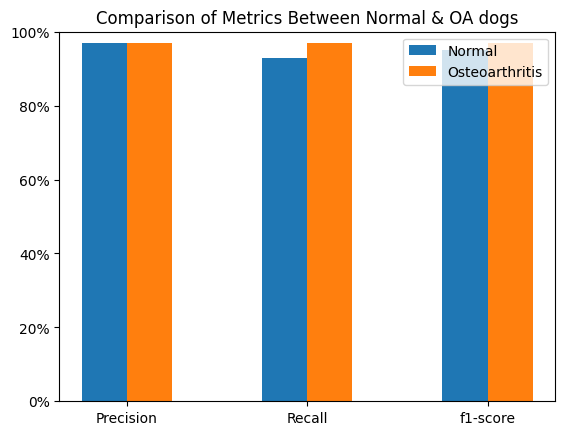

In [33]:
# Classification Report
report=classification_report(y_test,predicted_labels).split(" ")
report=[x for x in report if x != ""]

# Visualizing various metrics for Normal & OA dogs
Normal_metrics = {'Precision': float(report[5]), 'Recall': float(report[6]), 'f1-score': float(report[7])}
OA_metrics = {'Precision': float(report[10]), 'Recall': float(report[11]), 'f1-score': float(report[12])}

metric_names = list(Normal_metrics.keys())
names_values = list(Normal_metrics.values())
OA_values = list(OA_metrics.values())
num_metrics = len(metric_names)
bar_width = 0.25
indices = np.arange(num_metrics)
fig, ax = plt.subplots()
bars_Normal = ax.bar(indices - bar_width/2, names_values, bar_width, label='Normal')
bars_OA = ax.bar(indices + bar_width/2, OA_values, bar_width, label='Osteoarthritis')

ax.set_xticks(indices)
ax.set_xticklabels(metric_names)
ax.set_ylim(0, 1)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax.set_title('Comparison of Metrics Between Normal & OA dogs')
ax.legend()

plt.show()